In [2]:
from astropy.io import fits as fits
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

matplotlib.rcParams['figure.figsize']=[12,8]


In [3]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
"""
Based on code written by alechat
"""

import os
from subprocess import Popen, PIPE

def fits2npy(fits_file, idx_hdu):
    '''Read .fits containing the psf'''
    data = fits.getdata(fits_file, idx_hdu)
    nb_gal_row = data.shape[0]//96
    data_list = []
    idx_list = range(0, 10000)
    for i in idx_list:
        y = (96*i)%(nb_gal_row*96)
        x = i//nb_gal_row * 96
        data_list.append(data[x:x+96,y:y+96])
    return np.asarray(data_list)

def StampCollection2Mosaic(stamplist,gal_dim=96,nb_gal=10000):
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    mosaic=np.empty((nb_gal_row*gal_dim,nb_gal_row*gal_dim))
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        mosaic[x:x+gal_dim,y:y+gal_dim]=stamplist[i,:,:,0]
    return mosaic   

def compute_pixel_error(target_file, hdu_target, reconst_file, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1)):
    '''
    X: ground truth
    Y: estimated images
    '''
    nb_gal_row = int(np.sqrt(nb_gal)) #nb galaxies per row
    X = fits.getdata(target_file,hdu_target)
    Y = fits.getdata(reconst_file)
    DIFF=X-Y
    err = []
    for i in range(nb_gal):
        y = (gal_dim*i)%(nb_gal_row*gal_dim)
        x = i//nb_gal_row * gal_dim
        if gal_dim == 96:
            err.append((np.linalg.norm((DIFF[x:x+gal_dim,y:y+gal_dim])[xslice, 
                        yslice])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim][xslice, yslice])**2))
        else:
            err.append((np.linalg.norm(DIFF[x:x+gal_dim,y:y+gal_dim])**2)/(np.linalg.norm(X[x:x+gal_dim,y:y+gal_dim])**2))
    return err

def generate_shape_txt(gal_file, psf_file, output_file, gal_dim=96, mosaic_size=100, save_weights='', weights_input=''):
    print('Computing ellipticity for file: %s'%(gal_file))
    print('Saving result in: %s'%(output_file))
    executable = '/data/shapelens_v2/shapelens-CEA-master/bin/get_shapes'
    if weights_input in '-o-i':
        cmd = '%s %s %s -p %s -g %d -s %d -T %s | tee %s'%(executable, weights_input, save_weights, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    else:
        cmd = '%s -p %s -g %d -s %d -T %s | tee %s'%(executable, psf_file, mosaic_size, gal_dim, gal_file, output_file)
    print(cmd)
    cmd_file = 'get_shape.cmd'
    try:
        os.remove(cmd_file)
    except OSError:
        pass
    f = open(cmd_file, 'w')
    f.write('#! /bin/bash\n')
    f.write('source /home/fsureau/.bashrc\n')
    f.write(cmd)
    f.close()
    os.system('chmod 777 '+cmd_file)
    p = Popen('./'+cmd_file, stdout=PIPE, stderr=PIPE)
    stdout, stderr = p.communicate()
    return stdout, stderr

def get_target_shape(gal_file, output_file, idx=4):
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    images = fits.getdata(gal_file, idx)
    psfs = fits.getdata(gal_file, 3)
    fits.writeto(tmp_file, images)
    fits.writeto(tmp_psf_file, psfs)
    stdout, stderr = generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    return stdout, stderr

def get_ellipticity(file_name):
    ellip = []
    with open(file_name, 'r') as f:
        data = f.readlines()
    for l in data:
        ellip.append(np.array(l.split('\t')[3:5]).astype(np.float32))
    return np.asarray(ellip)

def compute_ellipticity_error(fileX, fileY, plot_hist=False, max_idx=10000):
    ellipX = get_ellipticity(fileX)[:max_idx]
    ellipY = get_ellipticity(fileY)[:max_idx]
    err = []
    for i in range(len(ellipY)):
        if (np.abs(ellipX[i]) > 1).any() or (np.abs(ellipY[i]) > 1).any():
            continue
        err.append(np.linalg.norm(ellipX[i]-ellipY[i]))
    if plot_hist:
        plt.figure()
        plt.hist(err, 100, range=(0,0.6))
        plt.show()
        print('Total samples = %d' %len(err))
    return err


def oracle_ellip(input_file, output_file, noise_std = 0):
    data = fits.getdata(input_file, 1)
    psf = fits.getdata(input_file, 3)
    if noise_std != 0:
        noise = np.random.normal(0, noise_std, size=data.shape)
        data += noise
    tmp_file = 'tmp'+str(np.random.randint(999))+'.fits'
    tmp_psf_file = 'tmp_psf'+str(np.random.randint(999))+'.fits'
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass
    fits.writeto(tmp_file, data)
    fits.writeto(tmp_psf_file, psf)
    generate_shape_txt(tmp_file, tmp_psf_file, output_file)
    try:
        os.remove(tmp_file)
    except OSError:
        pass
    try:
        os.remove(tmp_psf_file)
    except OSError:
        pass

In [5]:
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
testset_file = 'image-shfl-0-multihdu.fits'
# Input the hdf5 file, here we load a network trained on Tikhonov
#net_file = '/data/DeepDeconv/model/DenseNet_vsc_rangeSNR20to100_nol2norm.hdf5'
net_path= '/home/fsureau/programs/DeepDeconv/'
#net_file = 'DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5'
#net_file = 'UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100.hdf5'
net_root=net_file.replace('.hdf5','')


In [5]:
#im0=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",0)
#im1=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",1)
im2=fits.getdata("/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits",2)
#plt.imshow(im0[0:192,0:192])
#plt.figure()
#plt.imshow(im1[0:192,0:192])
#plt.figure()
#plt.imshow(im2[0:192,0:192])
#Create target file and save it
hdu_target=fits.PrimaryHDU(im2)
hdul = fits.HDUList([hdu_target])
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
hdul.writeto(write_path+'images/'+target_name,overwrite=True)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f156173a780>,
 <matplotlib.colorbar.Colorbar at 0x7f15616c41d0>)

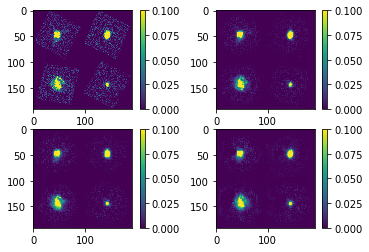

In [6]:
#Explore various results:
target_name=testset_file.replace('.fits','-target_fwhm0p07.fits')
SNR=100
target=fits.getdata(write_path+'images/'+target_name)
unet4x4x4_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4=fits.getdata(unet4x4x4_name)
unet4x4x4_res_name=write_path+"images/image-shfl-0-multihdu-UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
unet4x4x4_res=fits.getdata(unet4x4x4_res_name)
deconvnet_name=write_path+"images/image-shfl-0-multihdu-DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100_testSNR{0}.fits".format(SNR)
deconvnet=fits.getdata(deconvnet_name)

plt.subplot(2,2,1),plt.imshow(target[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,2),plt.imshow(unet4x4x4[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,3),plt.imshow(unet4x4x4_res[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()
plt.subplot(2,2,4),plt.imshow(deconvnet[0:192,0:192],vmin=0,vmax=0.1),plt.colorbar()


In [22]:
from DeepDeconv.utils.batch_utils import get_batch_from_fits
SNR_list_sim=[20,40,60,80,100]
for SNR_sim in SNR_list_sim:
    tt=get_batch_from_fits(write_path+'images/'+target_name,SNR=SNR_sim,deconv_mode=None)
    mosaic=StampCollection2Mosaic(tt[0])
    hdu_dnn=fits.PrimaryHDU(mosaic)
    hdul = fits.HDUList([hdu_dnn])
    mosaic_name=target_name.replace('.fits','_SNR{0}.fits'.format(SNR_sim))
    hdul.writeto(write_path+'images/'+mosaic_name,overwrite=True)
    err=compute_pixel_error(write_path+'images/'+target_name, 0, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
    np.savetxt(write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt'),np.array(err))
    print("SNR=",SNR_sim,"MEAN_ERR=",np.mean(err),"MEDIAN_ERR=",np.median(err))
    
#SNR= 20 MEAN_ERR= 4.937880697249189 MEDIAN_ERR= 4.824730749591655
#SNR= 40 MEAN_ERR= 1.2343629796334903 MEDIAN_ERR= 1.205882999616784
#SNR= 60 MEAN_ERR= 0.548571839026402 MEDIAN_ERR= 0.5355906941392824
#SNR= 80 MEAN_ERR= 0.3086940277687595 MEDIAN_ERR= 0.301980570765778
#SNR= 100 MEAN_ERR= 0.19755185976803796 MEDIAN_ERR= 0.19287156973596364


SNR= 20 MEAN_ERR= 4.937880697249189 MEDIAN_ERR= 4.824730749591655
SNR= 40 MEAN_ERR= 1.2343629796334903 MEDIAN_ERR= 1.205882999616784
SNR= 60 MEAN_ERR= 0.548571839026402 MEDIAN_ERR= 0.5355906941392824
SNR= 80 MEAN_ERR= 0.3086940277687595 MEDIAN_ERR= 0.301980570765778
SNR= 100 MEAN_ERR= 0.19755185976803796 MEDIAN_ERR= 0.19287156973596364


In [34]:
import sharedmem as sm
AFFINITY_FLAG = False

def sharedmem_pool(used_cores):
    # see https://stackoverflow.com/questions/15639779
    global AFFINITY_FLAG
    if not AFFINITY_FLAG:
        AFFINITY_FLAG = True
        os.system("taskset -p 0xfff %d" % os.getpid())
    if used_cores is None:
        used_cores = sm.cpu_count()-2
    return sm.MapReduce(np=used_cores)

print(sm.cpu_count())

8


In [42]:
import glob,os,fnmatch
#net_file = 'DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5'
#net_file = 'UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5'
#net_file='DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5'
net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5'
testset_file = 'image-shfl-0-multihdu.fits'
net_path= '/home/fsureau/programs/DeepDeconv/'
target_name="images/"+testset_file.replace('.fits','-target_fwhm0p07.fits')

net_file_list=fnmatch.filter(os.listdir(net_path),'*.hdf5')
net_file_list.sort()

SNR_list_sim=[20,40,60,80,100]

# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
    
used_cores=np.min((len(SNR_list_sim),sm.cpu_count()-2))  

for net_file in net_file_list:
    print(net_file)
    with sharedmem_pool(used_cores) as pool:
        def work(i):
            SNR_sim=SNR_list_sim[i]
            mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
            if os.path.isfile(write_path+'images/'+mosaic_name):
                write_txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt')
                if not os.path.isfile(write_txt_name):
                    with pool.critical:
                        print("Compute Pixel error {0}".format(mosaic_name) )
                    err=compute_pixel_error(write_path+target_name, 0, write_path+'images/'+mosaic_name, gal_dim=96, nb_gal=10000,xslice=slice(28,69,1),yslice=slice(28,69,1))
                    np.savetxt(write_txt_name,np.array(err))
                else:
                    err=np.loadtxt(write_txt_name)
                with pool.critical:
                    print(net_file," SNR=",SNR_sim,"MEAN_ERR=",np.median(err),"MEDIAN_ERR=",np.median(err))
            else:
                with pool.critical:
                    print("not existing {0}".format(mosaic_name) )

        pool.map(work, range(len(SNR_list_sim)))
    


DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5  SNR= 60 MEAN_ERR= 0.10470664615332845 MEDIAN_ERR= 0.10470664615332845
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5  SNR= 100 MEAN_ERR= 0.09226503233341643 MEDIAN_ERR= 0.09226503233341643
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5  SNR= 40 MEAN_ERR= 0.1176629842777012 MEDIAN_ERR= 0.1176629842777012
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5  SNR= 20 MEAN_ERR= 0.1546698537819034 MEDIAN_ERR= 0.1546698537819034
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_atrou_reshfl_SNR20to100_reshfl_SNR20to100.hdf5  SNR= 80 MEAN_ERR= 0.09682669408054391 MEDIAN_ERR= 0.09682669408054391
DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5


UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_SNR100.hdf5  SNR= 40 MEAN_ERR= 0.16171916507561218 MEDIAN_ERR= 0.16171916507561218
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5  SNR= 20 MEAN_ERR= 0.15269181529387643 MEDIAN_ERR= 0.15269181529387643
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5  SNR= 60 MEAN_ERR= 0.10391465803592373 MEDIAN_ERR= 0.10391465803592373
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5  SNR= 40 MEAN_ERR= 0.11662489517575572 MEDIAN_ERR= 0.11662489517575572
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5  SNR= 80 MEAN_ERR= 0.09626865154821254 MEDIAN_ERR= 0.09626865154821254
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5  SNR= 100 MEAN_ERR= 0.09094960580740016 MEDIAN_ERR= 0.09094960580740016
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5
UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SN

In [14]:
#net_file = 'DeconvNetRef_FCS_train2to20_val1_vsc_rangeSNR20to100.hdf5'
#net_file = 'UNet2D_FCS_sc2_layer2x2_relu_filt8_resNet.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_reshfl_SNR20to100.hdf5'
net_file='DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5'
#net_file='UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet_reshfl_SNR20to100.hdf5'
testset_file = 'image-shfl-0-multihdu.fits'
target_name="images/target-shfl-0-multihdu.fits"

SNR_list_sim=[20,40,60,80,100]
# Create the set of test with 10 observations at SNR 50
write_path="/data/DeepDeconv/benchmark/euclidpsf/"
print(net_file)
for SNR_sim in SNR_list_sim:
    mosaic_name=testset_file.replace('.fits','-'+net_file.replace('.hdf5','_testSNR{0}.fits'.format(SNR_sim)))
    txt_name=write_path+'stats/'+mosaic_name.replace('.fits','_pixelerr.txt')
    err=np.loadtxt(txt_name)
    print("SNR=",SNR_sim,"MEAN_ERR=",np.mean(err),"MEDIAN_ERR=",np.median(err))



DeconvNet2D_FCS_sc3_layer4x5x6_relu_growthRate12_reshfl_SNR20to100.hdf5
SNR= 20 MEAN_ERR= 0.16173035606494285 MEDIAN_ERR= 0.15178229720001604
SNR= 40 MEAN_ERR= 0.1277033696852865 MEDIAN_ERR= 0.11610745793922872
SNR= 60 MEAN_ERR= 0.11504851127151164 MEDIAN_ERR= 0.1027031862248386
SNR= 80 MEAN_ERR= 0.10860917000597099 MEDIAN_ERR= 0.09606153330168321
SNR= 100 MEAN_ERR= 0.10495943773938375 MEDIAN_ERR= 0.09188616278013079


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7fa8c0f75860>)

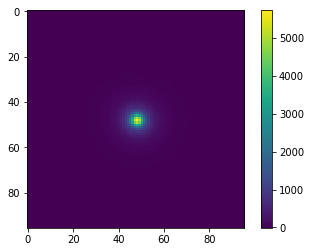

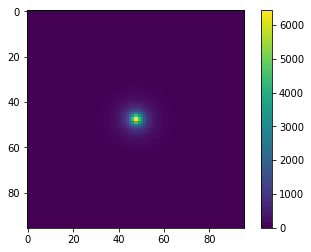

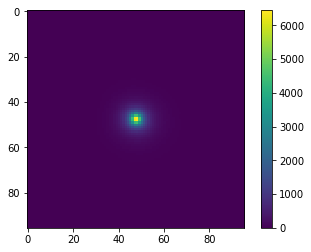

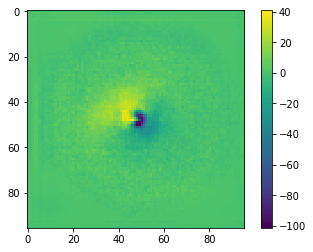

In [30]:
from matplotlib import pyplot as plt
plt.figure(),plt.imshow(np.sum(test_data[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(target_data[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(dnn_reconstruction[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(target_data[:,:,:,0]-dnn_reconstruction[:,:,:,0],axis=0)),plt.colorbar()#SNR=20,Oriented, [-70->80]

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f9b730b94a8>)

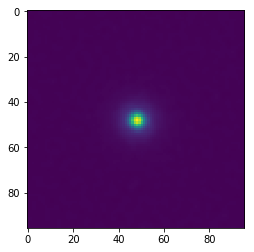

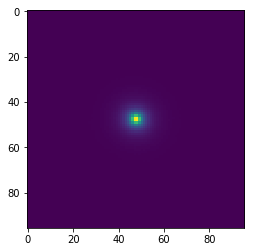

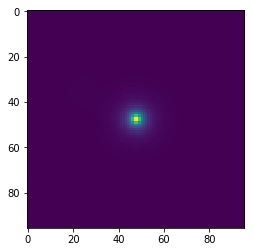

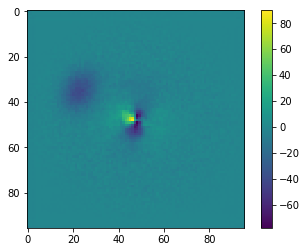

In [7]:
from matplotlib import pyplot as plt
plt.figure(),plt.imshow(np.sum(test_data[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(target_data[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(dnn_reconstruction[:,:,:,0],axis=0)),plt.colorbar()
plt.figure(),plt.imshow(np.sum(target_data[:,:,:,0]-dnn_reconstruction[:,:,:,0],axis=0)),plt.colorbar()#SNR=20,Oriented, [-70->80]



The DeepNet class also provides a method to extract intermediate features maps:

    get_layer_output(test_data, layer_idx)
    
layer_idx (int): idx of the layer whose features maps will be extracted.

Use dnn.model.summary() to retrieve the layers list.

In [ ]:
del dnn
k.clear_session()


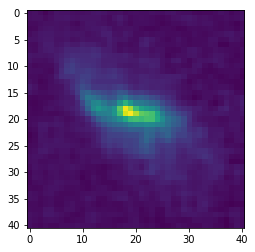

In [45]:
plt.imshow(dnn_reconstruction[0,slice(28,69,1),slice(28,69,1),0])


In [ ]:
# Suppose we want the last concatenation layer
idx = -4

# We print the name to check if you have the correct layer
print(dnn.model.layers[idx].name)

# We extract the features maps for the same data set as above.
# The layer has 48 neurons so we get an output of shape (10,96,96,48)
feat_maps = dnn.get_layer_output(test_data, layer_idx=idx)
print(feat_maps.shape)